# RemoteOK Job Scraper & Data Analysis Project

## Project Overview
This project scrapes remote job listings from RemoteOK.com across multiple categories, extracts key information (job titles, companies, skills, locations, job types), and performs comprehensive data analysis with visualizations.

## Objectives
- Scrape remote job postings from RemoteOK.com
- Extract and clean job data (title, company, skills, location, job type)
- Analyze job market trends through data visualizations
- Identify top skills in demand, job types, and companies hiring remotely


## Step 1: Import Required Libraries

We'll use:
- **Selenium**: For web automation and dynamic content loading
- **BeautifulSoup**: For HTML parsing and data extraction
- **Pandas**: For data manipulation and CSV export
- **Matplotlib/Seaborn**: For data visualization

In [ ]:
# Importing Dependencies
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from bs4 import BeautifulSoup
import pandas as pd
import time
import random
import re
from datetime import datetime, timedelta


## Step 2: Configuration Settings

Configure the scraper parameters:
- **Categories**: Job categories to scrape (engineer, management, design, etc.)
- **Delays**: Ethical scraping delays to avoid overloading the server
- **Job Limit**: Maximum number of jobs to collect

In [ ]:
# Configuration
BASE_URL = "https://remoteok.com/remote-{}-jobs"

CATEGORIES = [
    "engineer",
    "management",
    "design",
    "financial",
    "marketing",
    "support"
]

TOTAL_JOB_LIMIT = 500

PAGE_LOAD_DELAY = 5            # Delay after loading a page
SCROLL_DELAY = 3               # Delay between scrolls
CATEGORY_DELAY_RANGE = (2, 3)  # Random delay between categories
MAX_SCROLLS_PER_CATEGORY = 2


## Step 3: Web Scraper Functions

### 3.1 Driver Setup
Initialize Chrome WebDriver with appropriate options for web scraping.

In [ ]:
# Driver Setup
def create_driver():
    options = Options()
    options.add_argument("--start-maximized")
    return webdriver.Chrome(options=options)


**Complex Data Extraction Logic Explained:**

1. **Location Cleaning**: Uses regex to remove promotional text and special characters. If promotional text is detected, it extracts the actual location before separators (•, ·, |).

2. **Skills Extraction**: Combines two sources:
   - `data-tags` attribute from HTML
   - Visible tag elements (`.tag, .tags span`) from the page
   This ensures we capture all skills even if one source is missing.

3. **Job Type Inference**: Uses keyword matching in two stages:
   - First checks tags for job type keywords
   - If not found, searches the entire job row text
   This increases detection accuracy when job type isn't explicitly tagged.


### 3.2 Main Scraper Function

**Key Features:**
- Iterates through multiple job categories
- Scrolls pages to load dynamic content
- Extracts job data: title, company, skills, location, job type, date, URL
- **Data Cleaning Logic:**
  - **Location**: Removes promotional text and special characters using regex patterns
  - **Skills**: Combines data attributes and visible HTML elements to capture all tags
  - **Job Type**: Infers from tags and job description text using keyword matching
  

In [ ]:
# Scraper Function
def scrape_remoteok():
    driver = create_driver()
    all_jobs = []

    for category in CATEGORIES:
        if len(all_jobs) >= TOTAL_JOB_LIMIT:
            break

        url = BASE_URL.format(category)
        print(f"\nOpening category: {category.upper()}")
        driver.get(url)
        time.sleep(PAGE_LOAD_DELAY)

        # Scroll to load jobs
        for scroll in range(MAX_SCROLLS_PER_CATEGORY):
            driver.execute_script(
                "window.scrollTo(0, document.body.scrollHeight);"
            )
            time.sleep(SCROLL_DELAY)

            soup = BeautifulSoup(driver.page_source, "html.parser")
            job_rows = soup.find_all("tr", class_="job")

            print(
                f"  Scroll {scroll + 1}: "
                f"{len(job_rows)} jobs loaded | "
                f"{len(all_jobs)} collected"
            )

        soup = BeautifulSoup(driver.page_source, "html.parser")
        job_rows = soup.find_all("tr", class_="job")

        for job in job_rows:
            if len(all_jobs) >= TOTAL_JOB_LIMIT:
                break

            # ----------------- DATA EXTRACTION -----------------

            # Job title
            title = job.get("data-position")
            if not title:
                t = job.find("h2")
                title = t.get_text(strip=True) if t else None

            # Company name
            company = job.get("data-company")
            if not company:
                c = job.find("h3")
                company = c.get_text(strip=True) if c else None

            # Location (cleaned and de‑noised)
            location = job.get("data-location")
            if not location:
                loc_div = job.find("div", class_="location")
                if loc_div:
                    loc_text = loc_div.get_text(separator=" ", strip=True)
                else:
                    loc_text = ""

                # Remove promotional / non-location text such as
                # "ðŸ'° Upgrade to Premium to see salary"
                promo_patterns = [
                    "upgrade to premium to see salary",
                    "upgrade to premium",
                    "see salary",
                ]

                text_lower = loc_text.lower()
                if any(p in text_lower for p in promo_patterns):
                    # If there is a real location before separators like bullets (•, ·) or '|'
                    parts = re.split(r"[\u2022\u00b7\-|]", loc_text)
                    candidate = parts[0].strip() if parts else ""
                    location = candidate or "Remote"
                else:
                    location = loc_text or "Remote"
            else:
                location = location.strip()

            # Strip emojis / odd control chars and normalise whitespace
            location = re.sub(r"[^\x20-\x7E]+", " ", location)
            location = re.sub(r"\s+", " ", location).strip() or "Remote"

            # Tags / skills: use both data-tags attribute and visible tag elements
            tags = []

            raw_tags = job.get("data-tags")
            if raw_tags:
                tags.extend([t.strip() for t in raw_tags.split(",") if t.strip()])

            # Also collect visible tags rendered as pills/badges
            tag_elements = job.select(".tag, .tags span")
            existing_lower = {t.lower() for t in tags}
            for el in tag_elements:
                txt = el.get_text(strip=True)
                if txt and txt.lower() not in existing_lower:
                    tags.append(txt)
                    existing_lower.add(txt.lower())

            skills = ", ".join(tags) if tags else "N/A"

            # Job type: infer from tags and row text
            job_type = "N/A"
            type_keywords = {
                "full-time": "Full-time",
                "full time": "Full-time",
                "contract": "Contract",
                "part-time": "Part-time",
                "part time": "Part-time",
                "freelance": "Freelance",
                "internship": "Internship",
                "intern": "Internship",
                "temporary": "Temporary",
            }

            joined_tags_text = " ".join(tags).lower()
            for key, label in type_keywords.items():
                if key in joined_tags_text:
                    job_type = label
                    break

            if job_type == "N/A":
                row_text = job.get_text(separator=" ", strip=True).lower()
                for key, label in type_keywords.items():
                    if key in row_text:
                        job_type = label
                        break

            # Date posted
            time_tag = job.find("time")
            if time_tag:
                raw_time = time_tag.get_text(strip=True)

                match = re.search(r"(\d+)\s*d", raw_time)
                if match:
                    days_ago = int(match.group(1))
                    date_posted = (datetime.today() - timedelta(days=days_ago)).strftime("%d/%m/%y")
                else:
                    date_posted = "N/A"
            else:
                date_posted = "N/A"

            # Job URL
            link_tag = job.find("a", class_="preventLink")
            job_url = (
                "https://remoteok.com" + link_tag["href"]
                if link_tag and link_tag.get("href", "").startswith("/")
                else "N/A"
            )

            if not title or not company:
                continue

            all_jobs.append({
                "Job Title": title,
                "Company Name": company,
                "Job Tags / Skills": skills,
                "Location": location,
                "Job Type": job_type,
                "Date Posted": date_posted,
                "Job URL": job_url
            })

        delay = random.uniform(*CATEGORY_DELAY_RANGE)
        print(f"Sleeping {delay:.2f}s before next category...")
        time.sleep(delay)

    driver.quit()
    return all_jobs


### 3.3 Data Saving Function

Saves scraped data to CSV, removing duplicates based on job title, company, and URL.


In [ ]:
# Save Function
def save_data(jobs):
    if not jobs:
        print("No jobs scraped.")
        return None

    df = pd.DataFrame(jobs)
    df.drop_duplicates(
        subset=["Job Title", "Company Name", "Job URL"],
        inplace=True
    )

    df.to_csv("remoteok_jobs.csv", index=False)
    print(f"\nSaved {len(df)} jobs to remoteok_jobs.csv")
    return df


## Step 4: Execute Web Scraping

Run the scraper to collect job data from RemoteOK.com. This process may take several minutes as it:
- Visits multiple job categories
- Scrolls pages to load dynamic content
- Extracts and cleans data from each job listing
- Saves results to `remoteok_jobs.csv`


In [ ]:
# Running the scraper
print("Starting Ethical RemoteOK Scraping Project...")
jobs = scrape_remoteok()
df = save_data(jobs)


Starting Ethical RemoteOK Scraping Project...

Opening category: ENGINEER
  Scroll 1: 50 jobs loaded | 0 collected
  Scroll 2: 100 jobs loaded | 0 collected
Sleeping 2.76s before next category...

Opening category: MANAGEMENT
  Scroll 1: 8 jobs loaded | 100 collected
  Scroll 2: 8 jobs loaded | 100 collected
Sleeping 2.65s before next category...

Opening category: DESIGN
  Scroll 1: 50 jobs loaded | 108 collected
  Scroll 2: 100 jobs loaded | 108 collected
Sleeping 2.35s before next category...

Opening category: FINANCIAL
  Scroll 1: 96 jobs loaded | 258 collected
  Scroll 2: 96 jobs loaded | 258 collected
Sleeping 2.57s before next category...

Opening category: MARKETING
  Scroll 1: 100 jobs loaded | 354 collected
  Scroll 2: 150 jobs loaded | 354 collected
Sleeping 2.86s before next category...

Saved 415 jobs to remoteok_jobs.csv


## Step 5: Data Visualization & Analysis

### 5.1 Setup Visualization Environment

Import visualization libraries and load the scraped data.


In [ ]:
# Visualization Dependencies
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Load the data
df = pd.read_csv("remoteok_jobs.csv")
print(f"Loaded {len(df)} jobs for visualization")
print(f"\nData columns: {list(df.columns)}")
print(f"\nFirst few rows:")
df.head()


Loaded 415 jobs for visualization

Data columns: ['Job Title', 'Company Name', 'Job Tags / Skills', 'Location', 'Job Type', 'Date Posted', 'Job URL']

First few rows:


,Job Title,Company Name,Job Tags / Skills,Location,Job Type,Date Posted,Job URL
0,Full Stack Product Engineer,Jiga,"Senior, JavaScript, React, Node, Mongo, Full S...",United States,NaN,04/01/26,https://remoteok.com/remote-jobs/remote-full-s...
1,DevSecOps Engineer,Alpaca,"Design, Crypto, Security, Software, Financial,...",Remote - Global (Anywhere),NaN,NaN,https://remoteok.com/remote-jobs/remote-devsec...
2,Crypto Production Engineer,Wormhole Foundation,"Crypto, Security, Support, Operational, Reliab...",Upgrade to Premium to see salary,NaN,NaN,https://remoteok.com/remote-jobs/remote-crypto...
3,Product Engineer AuthKit,WorkOS,"SaaS, Support, Developer, Software, Growth, AP...",Probably worldwide,NaN,NaN,https://remoteok.com/remote-jobs/remote-produc...
4,Software Engineer Mid level API,CoinGecko,"Software, Design, Cryptocurrency, Front-End, B...",Malaysia,NaN,08/01/26,https://remoteok.com/remote-jobs/remote-softwa...


### 5.2 Data Preprocessing

Extract and count skills from the comma-separated skills column. This prepares the data for frequency analysis.


In [ ]:
# Data Preprocessing: Extract and count skills
all_skills = []
for skills_str in df["Job Tags / Skills"]:
    if pd.notna(skills_str) and skills_str != "N/A":
        skills_list = [s.strip() for s in str(skills_str).split(",")]
        all_skills.extend(skills_list)

# Count skill frequencies
skill_counts = Counter(all_skills)
print(f"Total unique skills found: {len(skill_counts)}")
print(f"\nTop 15 skills:")
for skill, count in skill_counts.most_common(15):
    print(f"  {skill}: {count}")


Total unique skills found: 189

Top 15 skills:
  Support: 171
  Technical: 144
  Growth: 142
  Senior: 140
  Software: 137
  Management: 130
  Lead: 129
  Engineering: 126
  Financial: 105
  Manager: 94
  Strategy: 87
  Security: 81
  Sales: 79
  Health: 78
  Cloud: 73


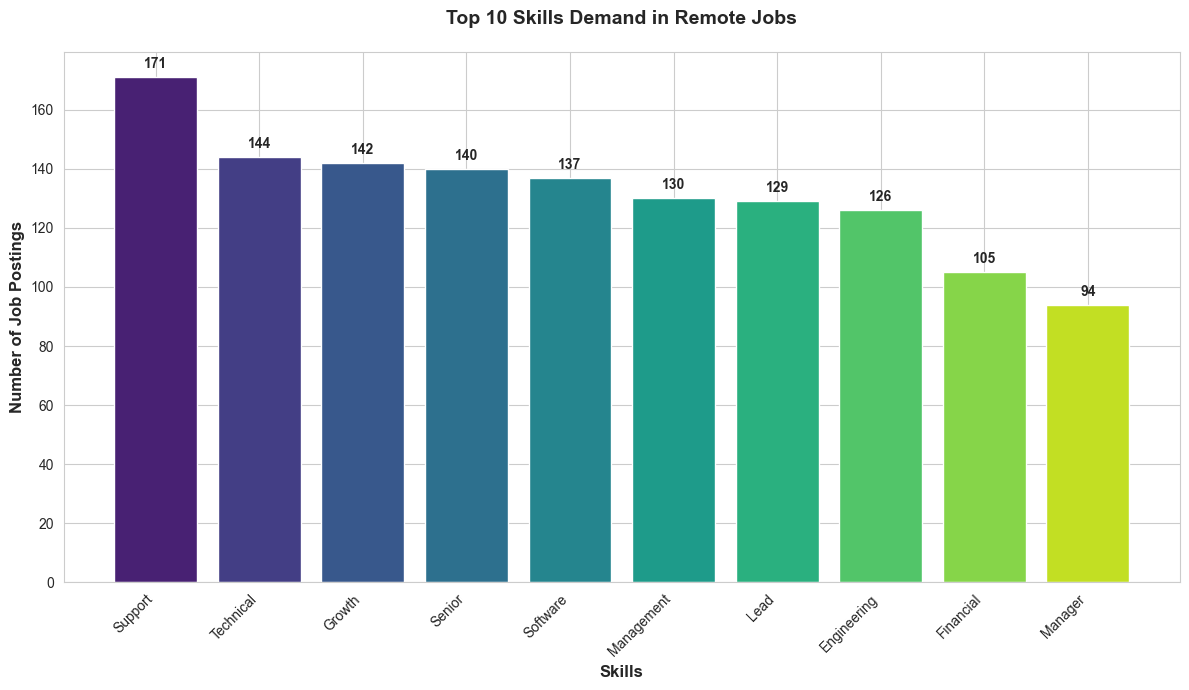


Top 10 Skills Summary:
  Support: 171 jobs
  Technical: 144 jobs
  Growth: 142 jobs
  Senior: 140 jobs
  Software: 137 jobs
  Management: 130 jobs
  Lead: 129 jobs
  Engineering: 126 jobs
  Financial: 105 jobs
  Manager: 94 jobs


In [ ]:
# Visualization 1: Top 10 Skills Demand (Bar Chart)
top_10_skills = dict(skill_counts.most_common(10))

plt.figure(figsize=(12, 7))
colors = sns.color_palette("viridis", len(top_10_skills))
bars = plt.bar(range(len(top_10_skills)), list(top_10_skills.values()), color=colors)

plt.xlabel("Skills", fontsize=12, fontweight='bold')
plt.ylabel("Number of Job Postings", fontsize=12, fontweight='bold')
plt.title("Top 10 Skills Demand in Remote Jobs", fontsize=14, fontweight='bold', pad=20)
plt.xticks(range(len(top_10_skills)), list(top_10_skills.keys()), rotation=45, ha='right')

# Add value labels on bars
for i, (skill, count) in enumerate(top_10_skills.items()):
    plt.text(i, count + 2, str(count), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nTop 10 Skills Summary:")
for skill, count in top_10_skills.items():
    print(f"  {skill}: {count} jobs")


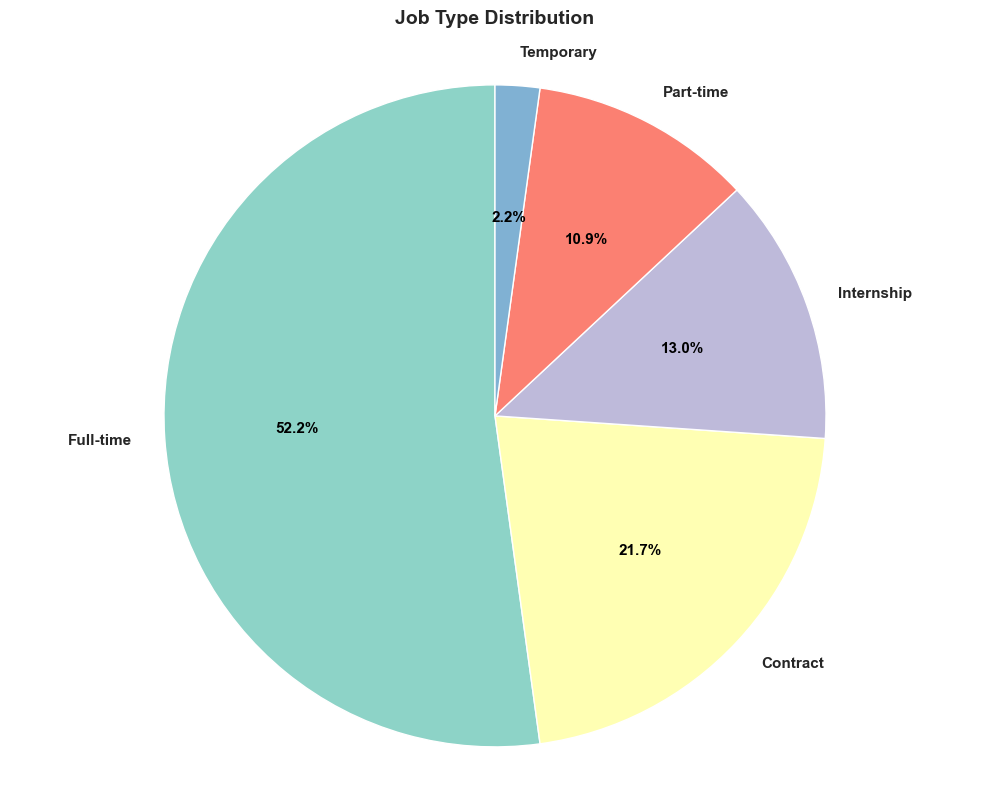


Job Type Distribution:
  Full-time: 24 jobs
  Contract: 10 jobs
  Internship: 6 jobs
  Part-time: 5 jobs
  Temporary: 1 jobs


In [ ]:
# Visualization 2: Job Type Distribution (Pie Chart)
job_type_counts = df["Job Type"].value_counts()

# Filter out N/A if it exists and create a cleaner view
if "N/A" in job_type_counts.index:
    job_type_counts_clean = job_type_counts.drop("N/A")
    na_count = job_type_counts["N/A"]
else:
    job_type_counts_clean = job_type_counts
    na_count = 0

plt.figure(figsize=(10, 8))
colors = sns.color_palette("Set3", len(job_type_counts_clean))
wedges, texts, autotexts = plt.pie(
    job_type_counts_clean.values,
    labels=job_type_counts_clean.index,
    autopct='%1.1f%%',
    colors=colors,
    startangle=90,
    textprops={'fontsize': 11, 'fontweight': 'bold'}
)

# Enhance autopct text
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontweight('bold')

plt.title("Job Type Distribution", fontsize=14, fontweight='bold', pad=20)

if na_count > 0:
    plt.figtext(0.5, 0.02, f"Note: {na_count} jobs have 'N/A' job type (not shown)", 
                ha='center', fontsize=9, style='italic')

plt.axis('equal')
plt.tight_layout()
plt.show()

print(f"\nJob Type Distribution:")
for job_type, count in job_type_counts.items():
    print(f"  {job_type}: {count} jobs")


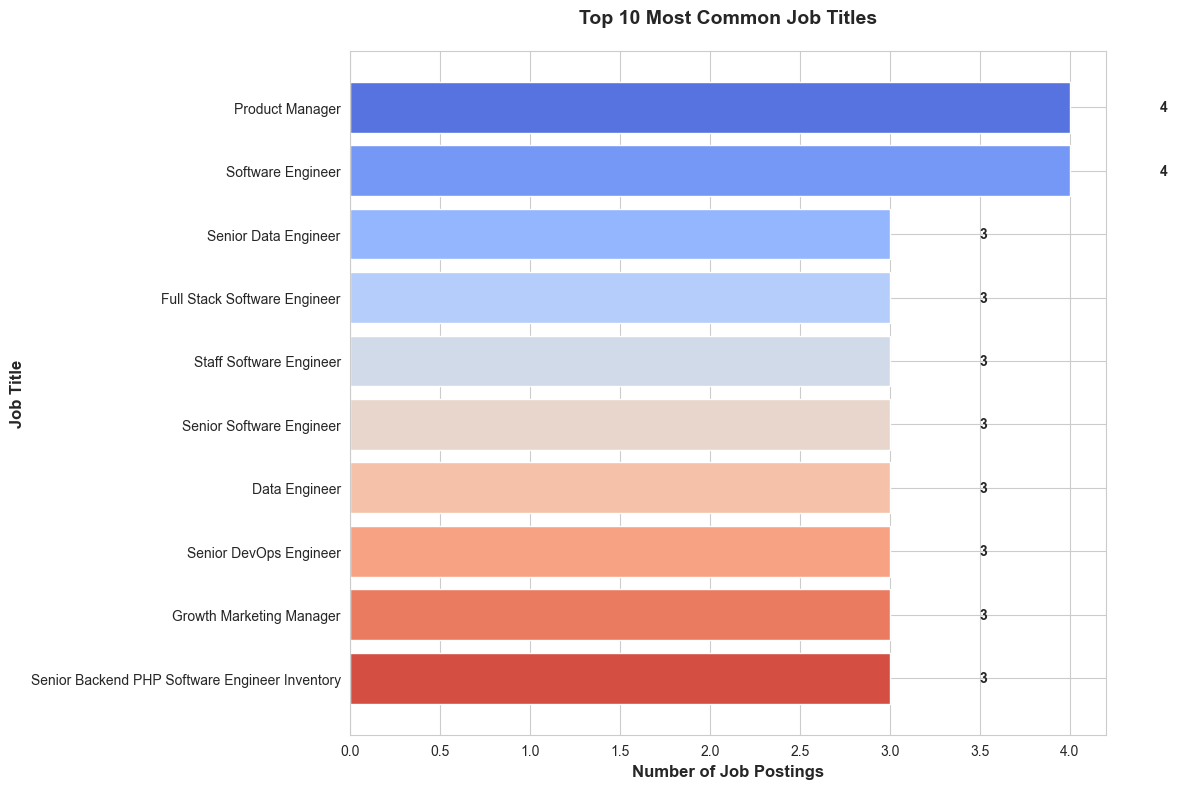


Top 10 Job Titles:
  Product Manager: 4 postings
  Software Engineer: 4 postings
  Senior Data Engineer: 3 postings
  Full Stack Software Engineer: 3 postings
  Staff Software Engineer: 3 postings
  Senior Software Engineer: 3 postings
  Data Engineer: 3 postings
  Senior DevOps Engineer: 3 postings
  Growth Marketing Manager: 3 postings
  Senior Backend PHP Software Engineer Inventory: 3 postings


In [ ]:
# Visualization 3: Top 10 Job Titles (Horizontal Bar Chart)
top_10_titles = df["Job Title"].value_counts().head(10)

plt.figure(figsize=(12, 8))
colors = sns.color_palette("coolwarm", len(top_10_titles))
bars = plt.barh(range(len(top_10_titles)), top_10_titles.values, color=colors)

plt.xlabel("Number of Job Postings", fontsize=12, fontweight='bold')
plt.ylabel("Job Title", fontsize=12, fontweight='bold')
plt.title("Top 10 Most Common Job Titles", fontsize=14, fontweight='bold', pad=20)
plt.yticks(range(len(top_10_titles)), top_10_titles.index)

# Add value labels on bars
for i, (title, count) in enumerate(top_10_titles.items()):
    plt.text(count + 0.5, i, str(count), va='center', fontweight='bold')

plt.gca().invert_yaxis()  # Top title at top
plt.tight_layout()
plt.show()

print(f"\nTop 10 Job Titles:")
for title, count in top_10_titles.items():
    print(f"  {title}: {count} postings")


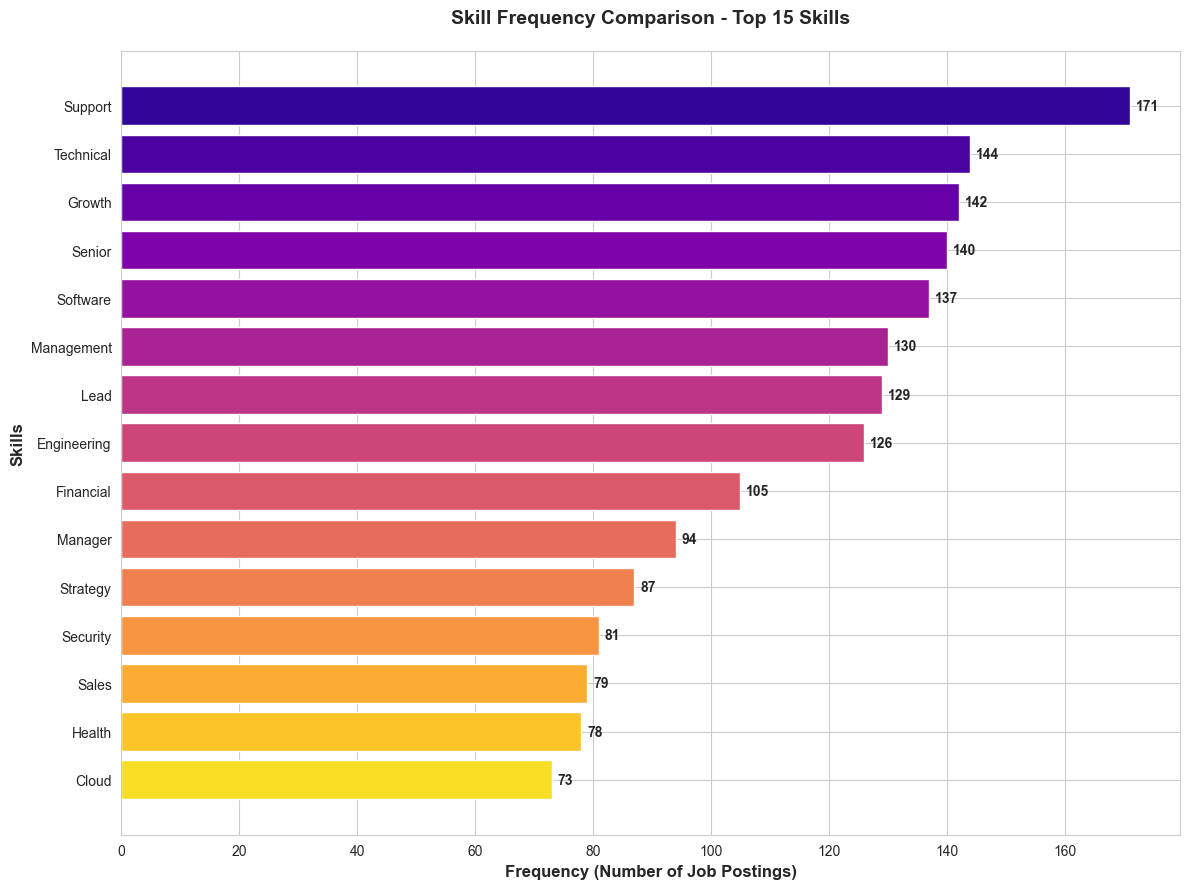


Top 15 Skills Frequency:
  Support: 171 occurrences
  Technical: 144 occurrences
  Growth: 142 occurrences
  Senior: 140 occurrences
  Software: 137 occurrences
  Management: 130 occurrences
  Lead: 129 occurrences
  Engineering: 126 occurrences
  Financial: 105 occurrences
  Manager: 94 occurrences
  Strategy: 87 occurrences
  Security: 81 occurrences
  Sales: 79 occurrences
  Health: 78 occurrences
  Cloud: 73 occurrences


In [ ]:
# Visualization 4: Skill Frequency Comparison (Horizontal Bar Chart)
# This shows the same top skills but in horizontal format for comparison
top_15_skills = dict(skill_counts.most_common(15))

plt.figure(figsize=(12, 9))
colors = sns.color_palette("plasma", len(top_15_skills))
bars = plt.barh(range(len(top_15_skills)), list(top_15_skills.values()), color=colors)

plt.xlabel("Frequency (Number of Job Postings)", fontsize=12, fontweight='bold')
plt.ylabel("Skills", fontsize=12, fontweight='bold')
plt.title("Skill Frequency Comparison - Top 15 Skills", fontsize=14, fontweight='bold', pad=20)
plt.yticks(range(len(top_15_skills)), list(top_15_skills.keys()))

# Add value labels on bars
for i, (skill, count) in enumerate(top_15_skills.items()):
    plt.text(count + 1, i, str(count), va='center', fontweight='bold')

plt.gca().invert_yaxis()  # Highest frequency at top
plt.tight_layout()
plt.show()

print(f"\nTop 15 Skills Frequency:")
for skill, count in top_15_skills.items():
    print(f"  {skill}: {count} occurrences")


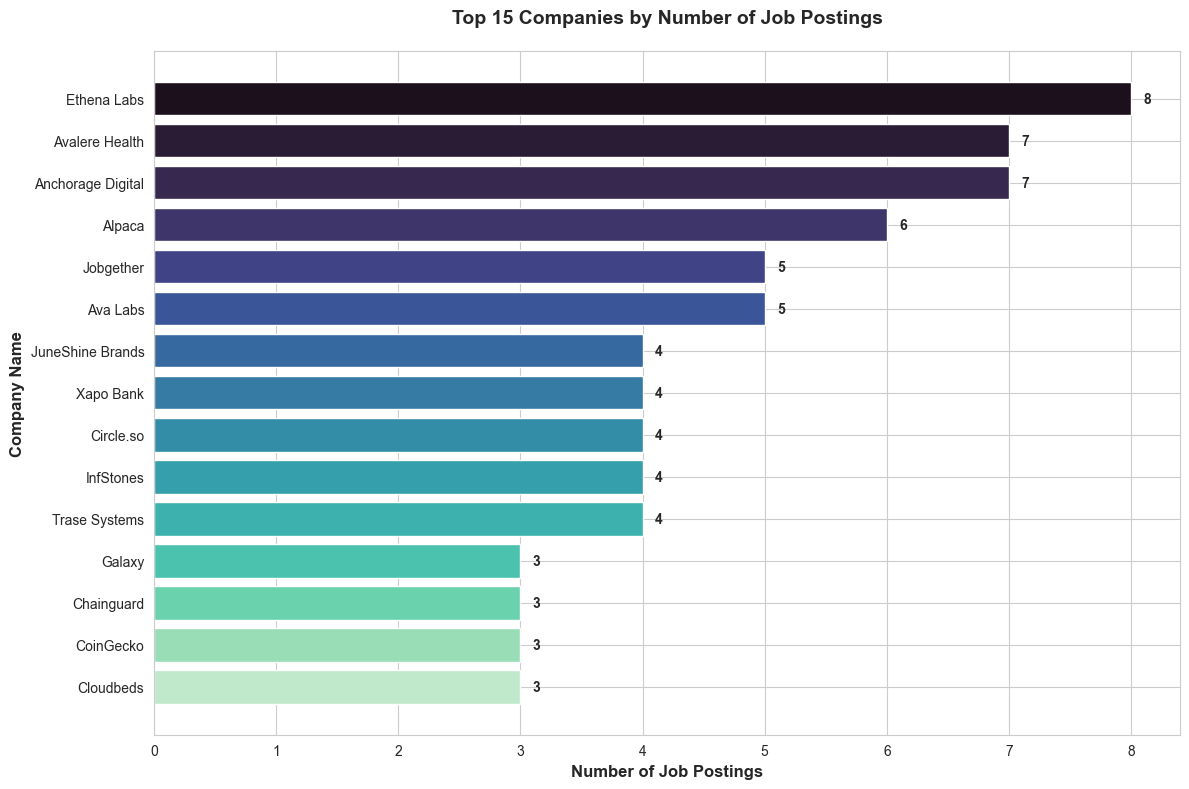


Top 15 Companies:
  Ethena Labs: 8 postings
  Avalere Health: 7 postings
  Anchorage Digital: 7 postings
  Alpaca: 6 postings
  Jobgether: 5 postings
  Ava Labs: 5 postings
  JuneShine Brands: 4 postings
  Xapo Bank: 4 postings
  Circle.so: 4 postings
  InfStones: 4 postings
  Trase Systems: 4 postings
  Galaxy: 3 postings
  Chainguard: 3 postings
  CoinGecko: 3 postings
  Cloudbeds: 3 postings


In [ ]:
# Additional Visualization 5: Top Companies by Job Postings
top_companies = df["Company Name"].value_counts().head(15)

plt.figure(figsize=(12, 8))
colors = sns.color_palette("mako", len(top_companies))
bars = plt.barh(range(len(top_companies)), top_companies.values, color=colors)

plt.xlabel("Number of Job Postings", fontsize=12, fontweight='bold')
plt.ylabel("Company Name", fontsize=12, fontweight='bold')
plt.title("Top 15 Companies by Number of Job Postings", fontsize=14, fontweight='bold', pad=20)
plt.yticks(range(len(top_companies)), top_companies.index)

# Add value labels
for i, (company, count) in enumerate(top_companies.items()):
    plt.text(count + 0.1, i, str(count), va='center', fontweight='bold')

plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print(f"\nTop 15 Companies:")
for company, count in top_companies.items():
    print(f"  {company}: {count} postings")


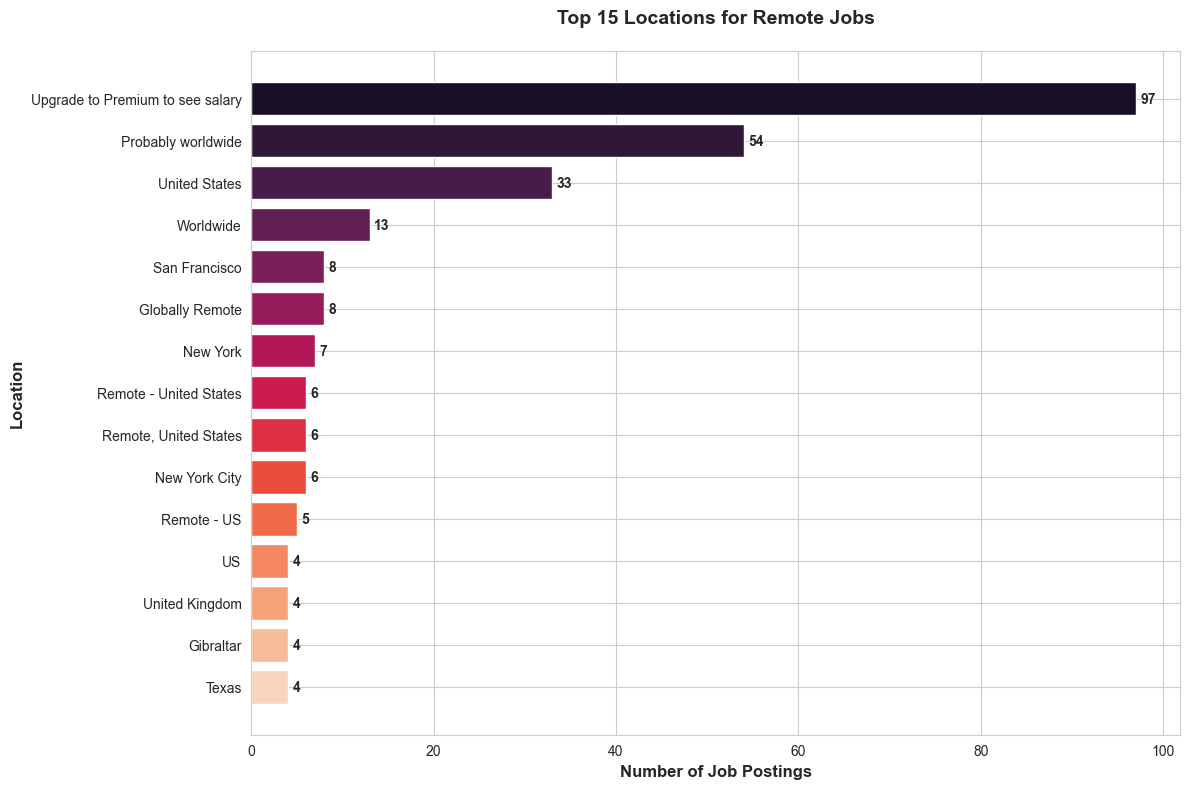


Top 15 Locations:
  Upgrade to Premium to see salary: 97 jobs
  Probably worldwide: 54 jobs
  United States: 33 jobs
  Worldwide: 13 jobs
  San Francisco: 8 jobs
  Globally Remote: 8 jobs
  New York: 7 jobs
  Remote - United States: 6 jobs
  Remote, United States: 6 jobs
  New York City: 6 jobs
  Remote - US: 5 jobs
  US: 4 jobs
  United Kingdom: 4 jobs
  Gibraltar: 4 jobs
  Texas: 4 jobs


In [ ]:
# Additional Visualization 6: Location Distribution (Top 15)
location_counts = df["Location"].value_counts().head(15)

plt.figure(figsize=(12, 8))
colors = sns.color_palette("rocket", len(location_counts))
bars = plt.barh(range(len(location_counts)), location_counts.values, color=colors)

plt.xlabel("Number of Job Postings", fontsize=12, fontweight='bold')
plt.ylabel("Location", fontsize=12, fontweight='bold')
plt.title("Top 15 Locations for Remote Jobs", fontsize=14, fontweight='bold', pad=20)
plt.yticks(range(len(location_counts)), location_counts.index)

# Add value labels
for i, (location, count) in enumerate(location_counts.items()):
    plt.text(count + 0.5, i, str(count), va='center', fontweight='bold')

plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print(f"\nTop 15 Locations:")
for location, count in location_counts.items():
    print(f"  {location}: {count} jobs")


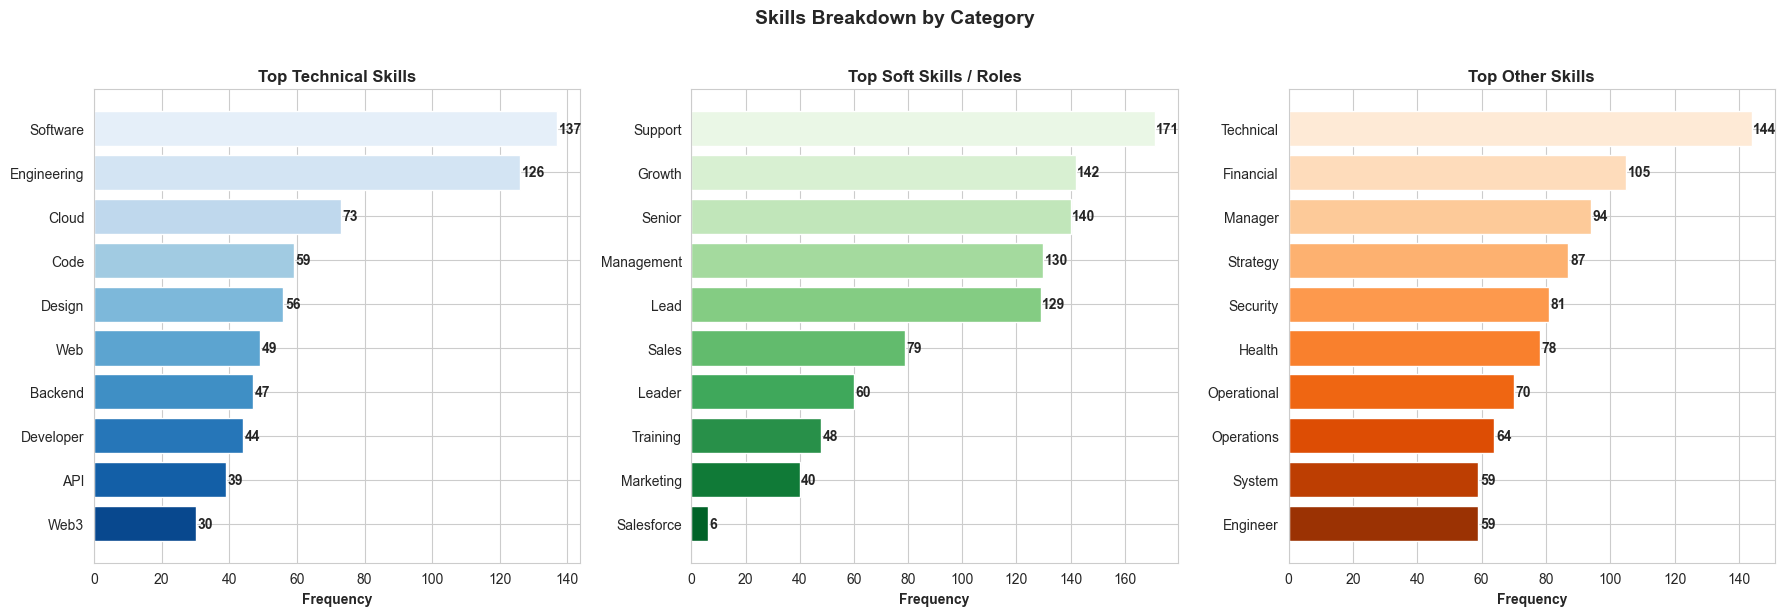

In [ ]:
# Additional Visualization 7: Skills Word Cloud Style Visualization
# Create a more detailed bar chart showing skill distribution with different categories
# Note: Skills are categorized using keyword matching
tech_skills = []
soft_skills = []
other_skills = []

# Categorize skills (basic categorization)
tech_keywords = ['python', 'javascript', 'java', 'react', 'node', 'api', 'cloud', 'backend', 
                 'front-end', 'frontend', 'software', 'code', 'engineering', 'developer',
                 'c++', 'go', 'sql', 'database', 'aws', 'docker', 'kubernetes', 'linux',
                 'ios', 'android', 'mobile', 'web', 'design', 'ui', 'ux']

soft_keywords = ['senior', 'lead', 'management', 'support', 'training', 'recruiting',
                 'growth', 'sales', 'marketing', 'communication']

for skill, count in skill_counts.items():
    skill_lower = skill.lower()
    if any(keyword in skill_lower for keyword in tech_keywords):
        tech_skills.append((skill, count))
    elif any(keyword in skill_lower for keyword in soft_keywords):
        soft_skills.append((skill, count))
    else:
        other_skills.append((skill, count))

# Get top skills from each category
top_tech = sorted(tech_skills, key=lambda x: x[1], reverse=True)[:10]
top_soft = sorted(soft_skills, key=lambda x: x[1], reverse=True)[:10]
top_other = sorted(other_skills, key=lambda x: x[1], reverse=True)[:10]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Technical Skills
if top_tech:
    tech_skills_list, tech_counts_list = zip(*top_tech)
    axes[0].barh(range(len(tech_skills_list)), tech_counts_list, color=sns.color_palette("Blues", len(tech_skills_list)))
    axes[0].set_yticks(range(len(tech_skills_list)))
    axes[0].set_yticklabels(tech_skills_list)
    axes[0].set_xlabel("Frequency", fontweight='bold')
    axes[0].set_title("Top Technical Skills", fontweight='bold', fontsize=12)
    axes[0].invert_yaxis()
    for i, count in enumerate(tech_counts_list):
        axes[0].text(count + 0.5, i, str(count), va='center', fontweight='bold')

# Soft Skills / Roles
if top_soft:
    soft_skills_list, soft_counts_list = zip(*top_soft)
    axes[1].barh(range(len(soft_skills_list)), soft_counts_list, color=sns.color_palette("Greens", len(soft_skills_list)))
    axes[1].set_yticks(range(len(soft_skills_list)))
    axes[1].set_yticklabels(soft_skills_list)
    axes[1].set_xlabel("Frequency", fontweight='bold')
    axes[1].set_title("Top Soft Skills / Roles", fontweight='bold', fontsize=12)
    axes[1].invert_yaxis()
    for i, count in enumerate(soft_counts_list):
        axes[1].text(count + 0.5, i, str(count), va='center', fontweight='bold')

# Other Skills
if top_other:
    other_skills_list, other_counts_list = zip(*top_other)
    axes[2].barh(range(len(other_skills_list)), other_counts_list, color=sns.color_palette("Oranges", len(other_skills_list)))
    axes[2].set_yticks(range(len(other_skills_list)))
    axes[2].set_yticklabels(other_skills_list)
    axes[2].set_xlabel("Frequency", fontweight='bold')
    axes[2].set_title("Top Other Skills", fontweight='bold', fontsize=12)
    axes[2].invert_yaxis()
    for i, count in enumerate(other_counts_list):
        axes[2].text(count + 0.5, i, str(count), va='center', fontweight='bold')

plt.suptitle("Skills Breakdown by Category", fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


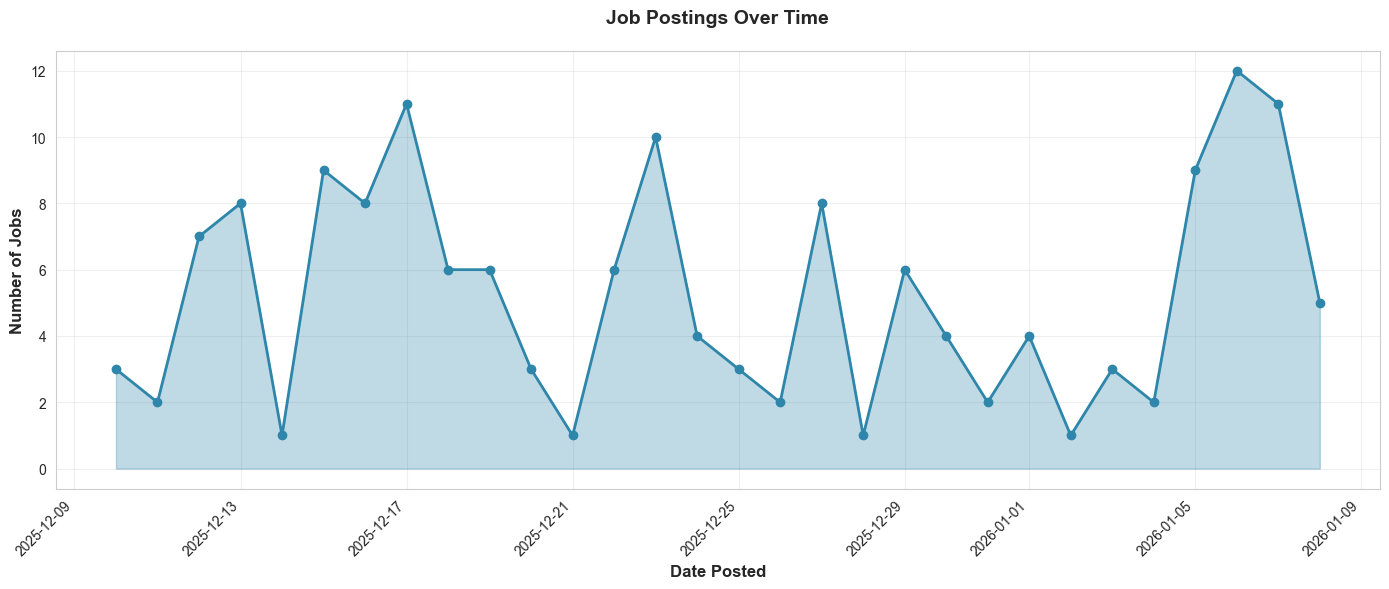


Jobs posted over time: 158 jobs with valid dates


In [ ]:
# Additional Visualization 8: Jobs Posted Over Time (if date data is available)
# Process date posted column
df_with_dates = df[df["Date Posted"] != "N/A"].copy()

if len(df_with_dates) > 0:
    # Convert date strings to datetime
    try:
        df_with_dates["Date Posted Parsed"] = pd.to_datetime(df_with_dates["Date Posted"], format="%d/%m/%y", errors='coerce')
        df_with_dates = df_with_dates.dropna(subset=["Date Posted Parsed"])
        
        if len(df_with_dates) > 0:
            df_with_dates = df_with_dates.sort_values("Date Posted Parsed")
            date_counts = df_with_dates["Date Posted Parsed"].dt.date.value_counts().sort_index()
            
            plt.figure(figsize=(14, 6))
            plt.plot(date_counts.index, date_counts.values, marker='o', linewidth=2, markersize=6, color='#2E86AB')
            plt.fill_between(date_counts.index, date_counts.values, alpha=0.3, color='#2E86AB')
            plt.xlabel("Date Posted", fontsize=12, fontweight='bold')
            plt.ylabel("Number of Jobs", fontsize=12, fontweight='bold')
            plt.title("Job Postings Over Time", fontsize=14, fontweight='bold', pad=20)
            plt.xticks(rotation=45, ha='right')
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
            
            print(f"\nJobs posted over time: {len(df_with_dates)} jobs with valid dates")
        else:
            print("No valid dates found after parsing")
    except Exception as e:
        print(f"Could not parse dates: {e}")
else:
    print("No date information available (all dates are N/A)")


In [ ]:
# Summary Statistics
print("=" * 60)
print("REMOTE JOBS DATA SUMMARY")
print("=" * 60)
print(f"\nTotal Jobs Scraped: {len(df)}")
print(f"Unique Companies: {df['Company Name'].nunique()}")
print(f"Unique Job Titles: {df['Job Title'].nunique()}")
print(f"Unique Skills: {len(skill_counts)}")
print(f"Total Skill Mentions: {sum(skill_counts.values())}")

print(f"\nJob Type Distribution:")
for job_type, count in df["Job Type"].value_counts().items():
    percentage = (count / len(df)) * 100
    print(f"  {job_type}: {count} ({percentage:.1f}%)")

print(f"\nTop 5 Most In-Demand Skills:")
for skill, count in skill_counts.most_common(5):
    percentage = (count / len(df)) * 100
    print(f"  {skill}: {count} jobs ({percentage:.1f}%)")

print(f"\nTop 5 Most Common Job Titles:")
for title, count in df["Job Title"].value_counts().head(5).items():
    print(f"  {title}: {count} postings")

print("\n" + "=" * 60)


REMOTE JOBS DATA SUMMARY

Total Jobs Scraped: 415
Unique Companies: 310
Unique Job Titles: 378
Unique Skills: 189
Total Skill Mentions: 3937

Job Type Distribution:
  Full-time: 24 (5.8%)
  Contract: 10 (2.4%)
  Internship: 6 (1.4%)
  Part-time: 5 (1.2%)
  Temporary: 1 (0.2%)

Top 5 Most In-Demand Skills:
  Support: 171 jobs (41.2%)
  Technical: 144 jobs (34.7%)
  Growth: 142 jobs (34.2%)
  Senior: 140 jobs (33.7%)
  Software: 137 jobs (33.0%)

Top 5 Most Common Job Titles:
  Product Manager: 4 postings
  Software Engineer: 4 postings
  Senior Data Engineer: 3 postings
  Full Stack Software Engineer: 3 postings
  Staff Software Engineer: 3 postings



## Conclusion

This project successfully demonstrates:

1. **Web Scraping**: Ethical scraping of RemoteOK.com using Selenium and BeautifulSoup
2. **Data Cleaning**: Advanced text processing to extract and clean job data (skills, locations, job types)
3. **Data Analysis**: Comprehensive visualizations revealing job market trends
4. **Key Insights**: 
   - Most in-demand skills in remote job market
   - Job type distribution patterns
   - Geographic distribution of opportunities
   - Top companies and job titles

The scraped data is saved to `remoteok_jobs.csv` for further analysis or integration with other systems.
